## Multiscale HiTS

### created by Yuying Liu, 05/07/2020

This script is a template for benchmarking multiscale HiTS against single time-scale neural network time-steppers. We find multiscale HiTS can provide the most accurate forecasts with good efficiency. 

With the help of this script, one can reproduce:
- Figure 5
- Table 5

In [1]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'Hyperbolic'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

In [3]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
ks = [2,3,4,5]#list(range(11))
step_sizes = [2**k for k in ks]
print(step_sizes)

[4, 8, 16, 32]


### load data & models

In [4]:
# load validation set and test set
val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))

In [5]:
# load models
model_by_step_size = {}
for step_size in step_sizes:
    models = list()
    # n_forward_list = [1, 2, 3, 4, 5, 10, 15, 20]
    # step_size = 4
    # for n_forward in n_forward_list:

    for n in range(10):
    #     print('load model_D{}.pt'.format(step_size))
        try:
            noise = 0.0
    #         model_name = 'model_D{}_noise{}_n_forward{}.pt'.format(step_size, noise, n_forward)
            model_name = 'model_D{}_{}.pt'.format(step_size, n)
            print('load ', model_name)
            models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
        except:
            break

    # fix model consistencies trained on gpus (optional)
    for model in models:
        model.device = 'cpu'
        model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
    model_by_step_size[str(step_size)] = models

load  model_D4_0.pt
load  model_D4_1.pt
load  model_D4_2.pt
load  model_D4_3.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


load  model_D4_4.pt
load  model_D4_5.pt
load  model_D4_6.pt
load  model_D4_7.pt
load  model_D4_8.pt
load  model_D4_9.pt
load  model_D8_0.pt
load  model_D8_1.pt
load  model_D8_2.pt
load  model_D8_3.pt
load  model_D8_4.pt
load  model_D8_5.pt
load  model_D8_6.pt
load  model_D8_7.pt
load  model_D8_8.pt
load  model_D8_9.pt
load  model_D16_0.pt
load  model_D16_1.pt
load  model_D16_2.pt
load  model_D16_3.pt
load  model_D16_4.pt
load  model_D16_5.pt
load  model_D16_6.pt
load  model_D16_7.pt
load  model_D16_8.pt
load  model_D16_9.pt
load  model_D32_0.pt
load  model_D32_1.pt
load  model_D32_2.pt
load  model_D32_3.pt
load  model_D32_4.pt
load  model_D32_5.pt
load  model_D32_6.pt
load  model_D32_7.pt
load  model_D32_8.pt
load  model_D32_9.pt


In [6]:
print(model_by_step_size.keys())

dict_keys(['4', '8', '16', '32'])


In [7]:
print(len(models))

10


### benchmarks

In [8]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

In [9]:
 def uni_scale_forecast(self, x_init, n_steps):
        """
        :param x_init: array of shape n_test x input_dim
        :param n_steps: number of steps forward in terms of dt
        :return: predictions of shape n_test x n_steps x input_dim and the steps
        """
        steps = list()
        preds = list()
        sample_steps = range(n_steps)

        # forward predictions
        x_prev = x_init
        cur_step = self.step_size - 1
        while cur_step < n_steps + self.step_size:
            x_next = self.forward(x_prev)
            steps.append(cur_step)
            preds.append(x_next)
            cur_step += self.step_size
            x_prev = x_next

        # include the initial frame
        steps.insert(0, 0)
        print(x_init[0])
        preds.insert(0, torch.tensor(x_init).float().to(self.device))
        
        print(preds[0][0])

        # interpolations
        preds = torch.stack(preds, 2).detach().numpy()
        cs = scipy.interpolate.interp1d(steps, preds, kind='linear')
        y_preds = torch.tensor(cs(sample_steps)).transpose(1, 2).float()
        print(y_preds[0,0])

        return y_preds

step_size =  4


  0%|          | 0/10 [00:00<?, ?it/s]

/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


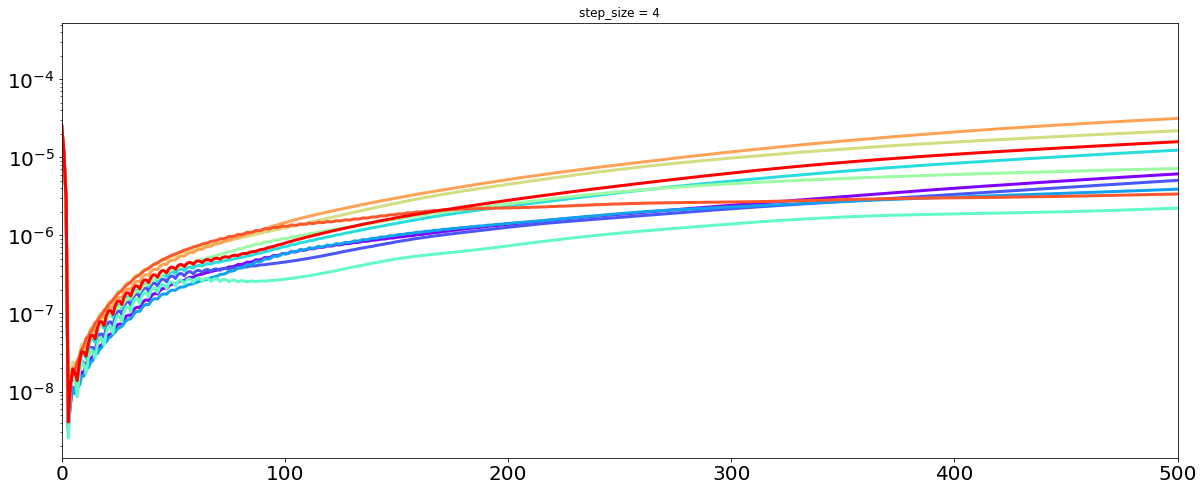

  0%|          | 0/10 [00:00<?, ?it/s]

step_size =  8


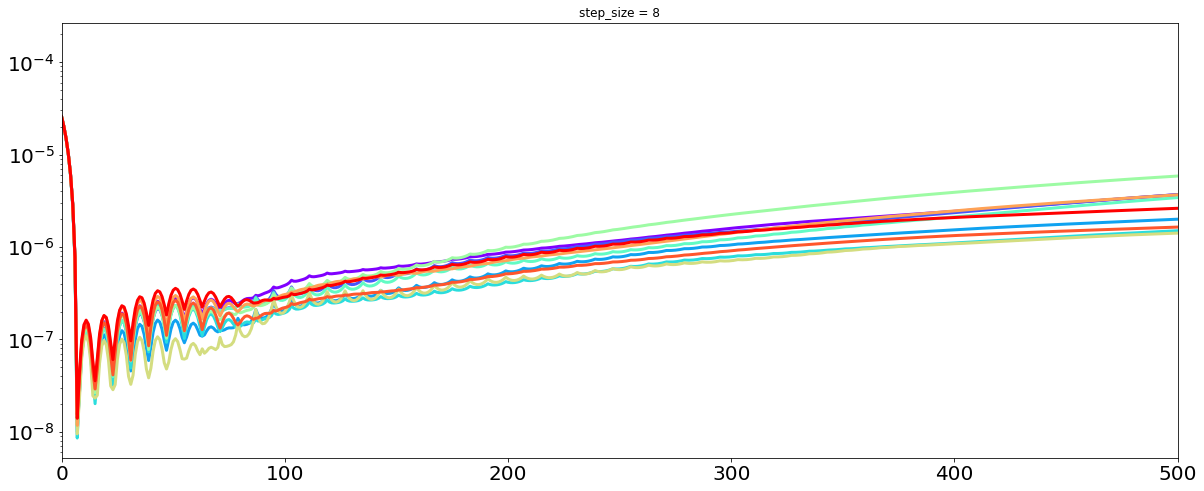

step_size =  16


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


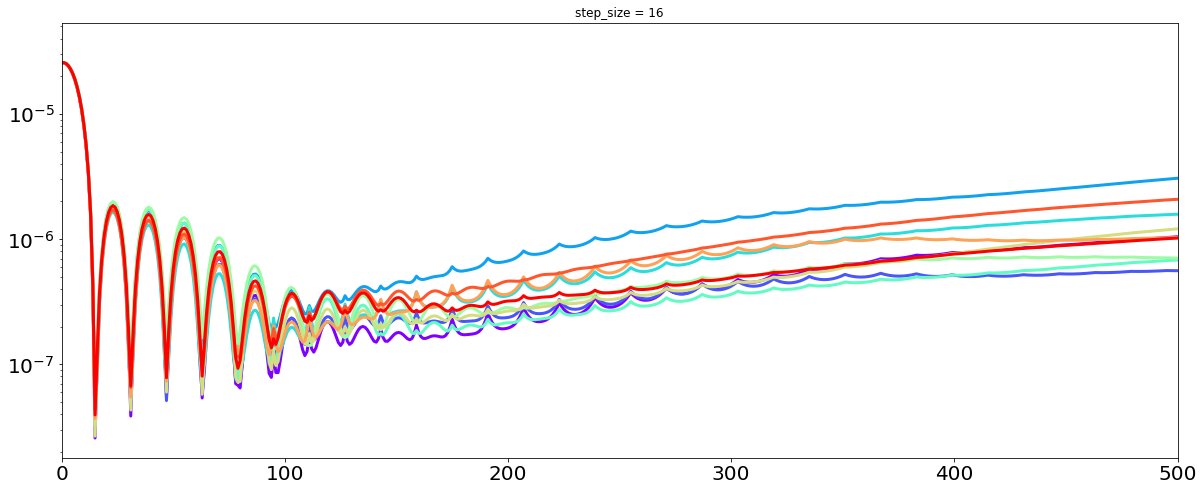

step_size =  32


  0%|          | 0/10 [00:00<?, ?it/s]

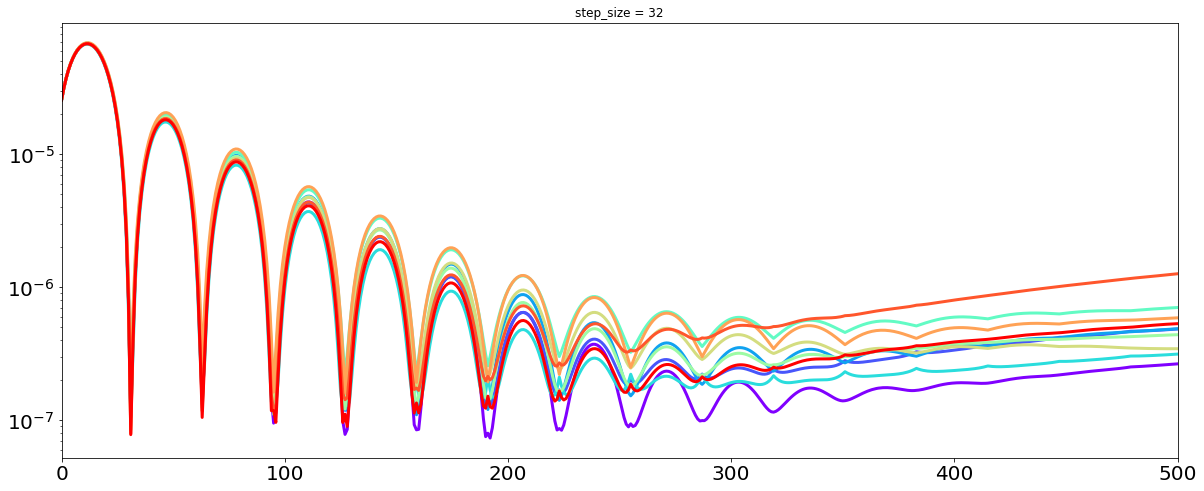

In [10]:
# uniscale time-stepping with NN
mse_by_step_size = {}
for step_size in step_sizes:
    preds_mse = list()
    times = list()

    models = model_by_step_size[str(step_size)]
    print("step_size = ", models[0].step_size)
    for model in tqdm(models):
        start = time.time()
        y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)

        end = time.time()
        times.append(end - start)
        preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))


    # visualize forecasting error at each time step    
    fig = plt.figure(figsize=(20, 8))
    colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
    for k in range(len(preds_mse)):
        err = preds_mse[k]
        mean = err.mean(0).detach().numpy()
        rgb = next(colors)
        plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0)#, label=n_forward_list[k])
    plt.xlim([0,500])
#     plt.legend(fontsize=20, loc='upper right')
    plt.title("step_size = " + str(step_size))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    mse_by_step_size[str(step_size)]= preds_mse

8


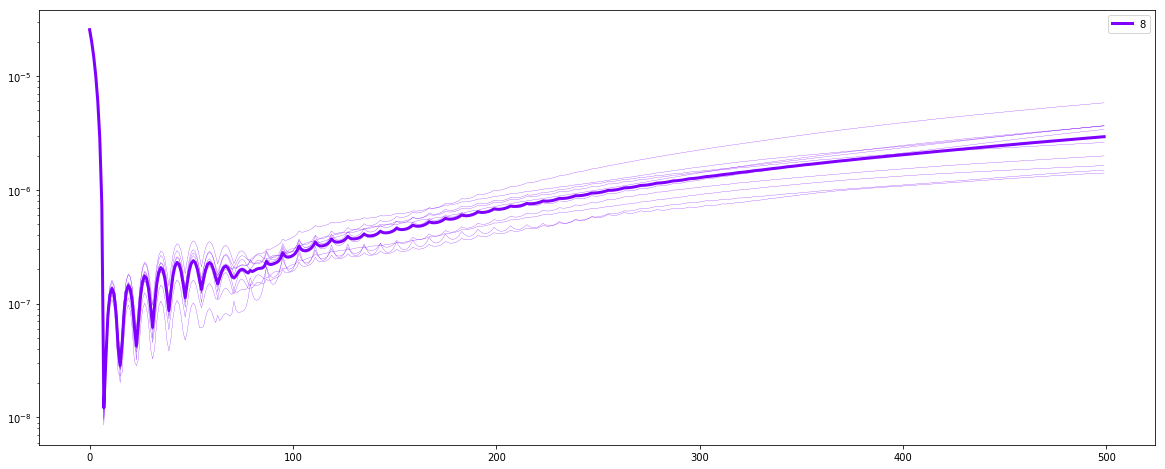

In [12]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
max_points = 500
for step_size in [8]:#step_sizes:
    print(step_size)
    sum_array = np.zeros(mse_by_step_size[str(step_size)][0].shape[1])
    rgb = next(colors)
    for mse in mse_by_step_size[str(step_size)]:
        mean = mse.mean(0).detach().numpy()
        
        plt.semilogy(mean[:max_points], color = rgb, linewidth=0.25)
        sum_array += mean
    plt.plot(sum_array[:max_points] / len(mse_by_step_size[str(step_size)]), color = rgb, linewidth=3, label = str(step_size))
    
plt.legend()
#     plt.show()
#     hj
#     print(torch.tensor(mse_by_step_size[str(step_size)]).shape)

In [14]:
#Resnet.py 

import torch
import numpy as np
import scipy.interpolate
from utils import DataSet


class NNBlock(torch.nn.Module):
    def __init__(self, arch, activation=torch.nn.ReLU()):
        """
        :param arch: architecture of the nn_block
        :param activation: activation function
        """
        super(NNBlock, self).__init__()

        # param
        self.n_layers = len(arch)-1
        self.activation = activation
        self.device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

        # network arch
        for i in range(self.n_layers):
            self.add_module('Linear_{}'.format(i), torch.nn.Linear(arch[i], arch[i+1]).to(self.device))

    def forward(self, x):
        """
        :param x: input of nn
        :return: output of nn
        """
        for i in range(self.n_layers - 1):
            x = self.activation(self._modules['Linear_{}'.format(i)](x))
        # no nonlinear activations in the last layer
        x = self._modules['Linear_{}'.format(self.n_layers - 1)](x)
        return x


class ResNet(torch.nn.Module):
    def __init__(self, arch, dt, step_size, prev_models, activation=torch.nn.ReLU()):
        """
        :param arch: a list that provides the architecture
        :param dt: time step unit
        :param step_size: forward step size
        :param activation: activation function in neural network
        """
        super(ResNet, self).__init__()

        # check consistencies
        assert isinstance(arch, list)
        assert arch[0] == arch[-1]

        # param
        self.n_dim = arch[0]

        # data
        self.dt = dt
        self.step_size = step_size

        # device
        self.device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

        # layer
        self.activation = activation
        self.add_module('increment', NNBlock(arch, activation=activation))
        
        # sort models by their step sizes (increasing order)
        step_sizes = [model.step_size for model in prev_models]
        models = [model for _, model in sorted(zip(step_sizes, prev_models), reverse=False)]
    
        self.prev_models = models
        
    def check_data_info(self, dataset):
        """
        :param: dataset: a dataset object
        :return: None
        """
        assert self.n_dim == dataset.n_dim
        assert self.dt == dataset.dt
        assert self.step_size == dataset.step_size

    def forward(self, x_init):
        """
        :param x_init: array of shape batch_size x input_dim
        :return: next step prediction of shape batch_size x input_dim
        """
        return x_init + self._modules['increment'](x_init)

    def uni_scale_forecast(self, x_init, n_steps):
        """
        :param x_init: array of shape n_test x input_dim
        :param n_steps: number of steps forward in terms of dt
        :return: predictions of shape n_test x n_steps x input_dim and the steps
        """
        steps = list()
        preds = list()
        sample_steps = range(n_steps)

        # forward predictions
        x_prev = x_init
        cur_step = self.step_size - 1
        while cur_step < n_steps + self.step_size:
            x_next = self.forward(x_prev)
            steps.append(cur_step)
            preds.append(x_next)
            cur_step += self.step_size
            x_prev = x_next

        # include the initial frame
        steps.insert(0, 0)
        preds.insert(0, torch.tensor(x_init).float().to(self.device))

        # interpolations
        preds = torch.stack(preds, 2).detach().numpy()
        cs = scipy.interpolate.interp1d(steps, preds, kind='linear')
        y_preds = torch.tensor(cs(sample_steps)).transpose(1, 2).float()

        return y_preds

    def train_net(self, dataset, max_epoch, batch_size, w=1.0, lr=1e-3, model_path=None):
        """
        :param dataset: a dataset object
        :param max_epoch: maximum number of epochs
        :param batch_size: batch size
        :param w: l2 error weight
        :param lr: learning rate
        :param model_path: path to save the model
        :return: None
        """
        # check consistency
        self.check_data_info(dataset)

        # training
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        best_loss = 1e+5
        while epoch < max_epoch:
            epoch += 1
            # ================= prepare data ==================
            n_samples = dataset.n_train
            new_idxs = torch.randperm(n_samples)
            batch_x = dataset.train_x[new_idxs[:batch_size], :].to(self.device)
            batch_ys = dataset.train_ys[new_idxs[:batch_size], :, :].to(self.device)
            # =============== calculate losses ================
            train_loss = self.calculate_loss(batch_x, batch_ys, w=w)
            val_loss = self.calculate_loss(dataset.val_x, dataset.val_ys, w=w)
            # ================ early stopping =================
            if best_loss <= 1e-8:
                print('--> model has reached an accuracy of 1e-8! Finished training!')
                break
            # =================== backward ====================
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            # =================== log =========================
            if epoch % 10 == 0:
                print('epoch {}, training loss {}, validation loss {}'.format(epoch, train_loss.item(),
                                                                              val_loss.item()))
                if val_loss.item() < best_loss:
                    best_loss = val_loss.item()
                    if model_path is not None:
                        print('(--> new model saved @ epoch {})'.format(epoch))
                        torch.save(self, model_path)

        # if to save at the end
        if val_loss.item() < best_loss and model_path is not None:
            print('--> new model saved @ epoch {}'.format(epoch))
            torch.save(self, model_path)

    def calculate_loss(self, x, ys, w=1.0):
        """
        :param x: x batch, array of size batch_size x n_dim
        :param ys: ys batch, array of size batch_size x n_steps x n_dim
        :return: overall loss
        """
        torch.autograd.set_detect_anomaly(True)
        batch_size, n_steps, n_dim = ys.size()
        assert n_dim == self.n_dim
        
        #we want to get next 10 timesteps 
        #smallest is dt = 1
        #middle is dt = 2
        #this one is dt = 4
        n_steps = 5
        y_preds = torch.zeros(batch_size, n_steps, n_dim).float().to(self.device)
        
        #first step we care about is after 1 big step
        y_preds[:,0,:] = self.forward(x)
        #next step is big plus little
        y_preds[:,1,:] = self.prev_models[0](self.forward(x))
        
        #next step is big plus mid
        y_preds[:,2,:] = self.prev_models[1](self.forward(x))
        
        #next is big, mid, small
        y_preds[:,3,:] = self.prev_models[0](self.prev_models[1](self.forward(x)))
        
        #last is two big 
        y_preds[:,4,:] = self.forward(self.forward(x))
        
        truth = ys[:,[4, 5, 6, 7, 8]]
#         truth = ys[:, [self.step_size, self.step_size + self.models[0].step_size, self.step_size + self.models[1].step_size, 
#                        self.step_size + self.models[1].step_size+  self.models[0].step_size, self.step_size*2]]
        
        
        
#         print(y_preds)
#         hjk
        
        
        
#         #find vectorized with the model for 10 steps
#         n_steps = 5
#         models = self.prev_models.copy()
#         models.append(self)
#         y_preds = vectorized_multi_scale_forecast(x.to(self.device), n_steps, models)
        
        # compute loss
        criterion = torch.nn.MSELoss(reduction='none')
        loss = w * criterion(y_preds, truth).mean() + (1-w) * criterion(y_preds, truth).max()
        

#         # forward (recurrence)
#         y_preds = torch.zeros(batch_size, n_steps, n_dim).float().to(self.device)
#         y_prev = x
#         for t in range(n_steps):
#             y_next = self.forward(y_prev)
#             y_preds[:, t, :] = y_next
#             y_prev = y_next

#         # compute loss
#         criterion = torch.nn.MSELoss(reduction='none')
#         loss = w * criterion(y_preds, ys).mean() + (1-w) * criterion(y_preds, ys).max()

        return loss



def vectorized_multi_scale_forecast(x_init, n_steps, models):
    """
    :param x_init: initial state torch array of shape n_test x n_dim
    :param n_steps: number of steps forward in terms of dt
    :param models: a list of models
    :return: a torch array of size n_test x n_steps x n_dim,
             a list of indices that are not achieved by interpolations
    """
    
    # sort models by their step sizes (decreasing order)
    step_sizes = [model.step_size for model in models]
    models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

    # we assume models are sorted by their step sizes (decreasing order)
    n_test, n_dim = x_init.shape
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    indices = list()
    extended_n_steps = n_steps + models[0].step_size
    preds = torch.zeros(n_test, extended_n_steps + 1, n_dim,requires_grad=True).float().to(device)

    # vectorized simulation
    indices.append(0)
    print(x_init.requires_grad)
    print(preds.requires_grad)
    preds[:, 0, :] = x_init
    print(preds.requires_grad)
    total_step_sizes = n_steps
    for model in models:
        n_forward = int(total_step_sizes/model.step_size)
        y_prev = preds[:, indices, :].reshape(-1, n_dim)
        indices_lists = [indices]
        for t in range(n_forward):
            y_next = model(y_prev.to(device)).to(device)
            shifted_indices = [x + (t + 1) * model.step_size for x in indices]
            indices_lists.append(shifted_indices)
            preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)
            y_prev = y_next
        indices = [val for tup in zip(*indices_lists) for val in tup]
        total_step_sizes = model.step_size - 1

    # simulate the tails
    last_idx = indices[-1]
    y_prev = preds[:, last_idx, :]
    while last_idx < n_steps:
        last_idx += models[-1].step_size
        y_next = models[-1](y_prev)
        preds[:, last_idx, :] = y_next
        indices.append(last_idx)
        y_prev = y_next

    # interpolations
    sample_steps = range(1, n_steps+1)
    valid_preds = preds[:, indices, :].detach().numpy()
    cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
    y_preds = torch.tensor(cs(sample_steps)).float()

    return y_preds
models_depends = list()
ks = [1,2,3]#list(range(11))
step_sizes = [2**k for k in ks]
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models_depends.append(torch.load(os.path.join(model_dir, 'model_D{}_noise{}_depends.pt'.format(step_size, noise)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_depends:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
    
models_depends1 = list()
ks = [3]
step_sizes = [2**k for k in ks]
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models_depends1.append(torch.load(os.path.join(model_dir, 'model_D{}_noise{}_depends1.pt'.format(step_size, noise)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_depends1:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
models_depends2 = list()
ks = [3]
step_sizes = [2**k for k in ks]
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models_depends2.append(torch.load(os.path.join(model_dir, 'model_D{}_noise{}_depends2.pt'.format(step_size, noise)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_depends1:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
    

load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D8.pt
load model_D8.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:638: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:638: UserWarning: Couldn't retrieve source code for container of type NNBlock. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChang

In [15]:
y_preds_8_depends = models_depends[2].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
y_preds_8_depends1 = models_depends1[0].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
y_preds_8_depends2 = models_depends2[0].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


8


Text(0.5,1,'Hyperbolic mse')

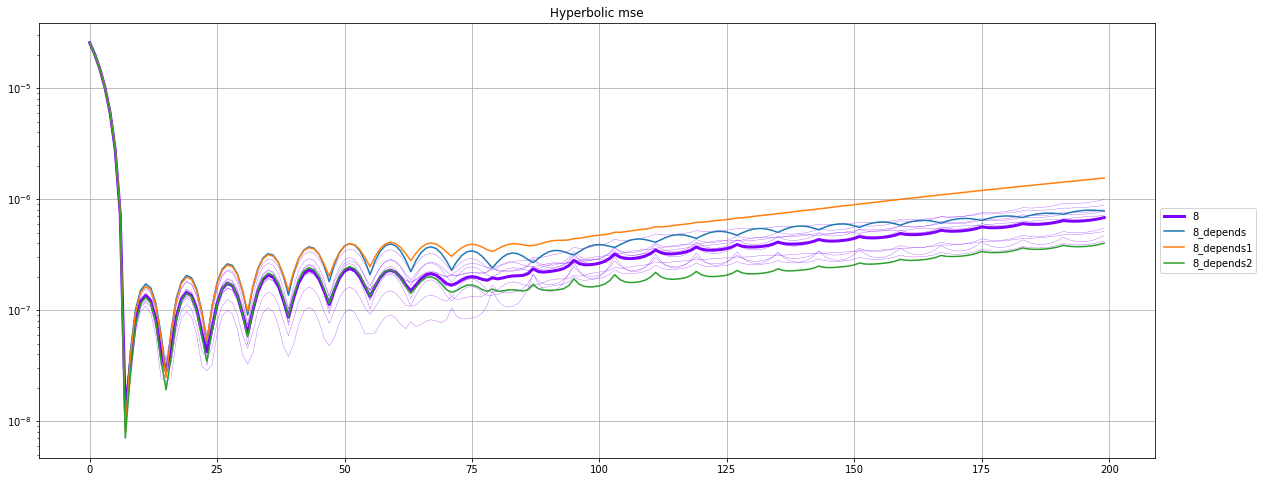

In [19]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
max_points = 200
for step_size in [8]:#step_sizes:
    print(step_size)
    sum_array = np.zeros(mse_by_step_size[str(step_size)][0].shape[1])
    rgb = next(colors)
    for mse in mse_by_step_size[str(step_size)]:
        mean = mse.mean(0).detach().numpy()
        
        plt.semilogy(mean[:max_points], color = rgb, linewidth=0.25)
        sum_array += mean
    plt.plot(sum_array[:max_points] / len(mse_by_step_size[str(step_size)]), color = rgb, linewidth=3, label = str(step_size))
    
plt.legend()

#plot mse of all fittings
# fig = plt.figure(figsize=(20, 8))
n_max = max_points

# mse = torch.mean((y_preds_4_bigger - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
# plt.semilogy(mse[:n_max], label = "4_bigger")

# mse = torch.mean((y_preds_8 - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
# plt.semilogy(mse[:n_max], label = "8")
mse = torch.mean((y_preds_8_depends - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
plt.semilogy(mse[:n_max], label = "8_depends")
mse = torch.mean((y_preds_8_depends1 - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
plt.semilogy(mse[:n_max], label = "8_depends1")
mse = torch.mean((y_preds_8_depends2 - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
plt.semilogy(mse[:n_max], label = "8_depends2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.title("Hyperbolic mse")

4.653022e-08
6.5178675e-08
4.31448e-08
8.2860346e-08
5.63087e-08
8.3649894e-08
1.2130336e-07
1.033781e-07
1.16498725e-07
9.239763e-08
[4.653022e-08, 6.5178675e-08, 4.31448e-08, 8.2860346e-08, 5.63087e-08, 8.3649894e-08, 1.2130336e-07, 1.033781e-07, 1.16498725e-07, 9.239763e-08]
max =  1.2130336e-07
min =  4.31448e-08


In [15]:
# cross validation (model selections) 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5
# choose the largest time step
for i in tqdm(range(len(models))):
#     print("val_data devioce = ", val_data.device)?
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float().to('cpu'), n_steps=n_steps, models=models[:len(models)-i])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

        # choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float().to('cpu'), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]

  0%|          | 0/10 [00:00<?, ?it/s]

TypeError: '<' not supported between instances of 'ResNet' and 'ResNet'

In [ ]:
# multiscale time-stepping with NN
start = time.time()
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
end = time.time()
multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.semilogy(t, multiscale_err, linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

In [ ]:
# integration of a sampled test trial 
# (you need to change the code here accordingly as state variables are different for different systems)
idx = 15
t = np.linspace(0, (n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(t, test_data[idx, 0:n_steps, 0], 'r-', linewidth=10, label='x')
ax0.plot(t, test_data[idx, 0:n_steps, 1], 'b-', linewidth=10, label='y')
# ax0.plot(t, test_data[idx, 0:n_steps, 2], 'g-', linewidth=10, label='z')
ax0.plot(t, y_preds[idx, 0:n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='learned')
ax0.plot(t, y_preds[idx, 0:n_steps, 1].detach().numpy(), 'k--', linewidth=10)
# ax0.plot(t, y_preds[idx, 0:n_steps, 2].detach().numpy(), 'k--', linewidth=10)
ax0.legend(fontsize=50, loc='upper right')
ax0.tick_params(axis='both', which='major', labelsize=60)

In [ ]:
# computation time
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('ensembled multiscale model: computing time {}s'.format(multiscale_time))